In [ ]:
gfrom google.colab import files
uploaded = files.upload()

Saving NAT_v2_Catalogue.csv.txt to NAT_v2_Catalogue.csv.txt


**Step One: Importing the dataset, loading necessary packages + importing them**

In [ ]:
# Downloading necessary packages
!pip install spacy
!python -m spacy download it_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 80.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('it_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# Importing and downloading necessary packages
import re
import pandas as pd
import spacy
from spacy.lang.it.stop_words import STOP_WORDS as SPACY_STOPWORDS

In [ ]:
import pandas as pd

# Importing the dataset
df = pd.read_csv("NAT_v2_Catalogue.csv.txt")

In [ ]:
# Exploring the 5 first rows of the dataset for each column
df.head()

,id,title,cleaned_text,published_date,top_image,videos,keywords,summary,meta_description,tags,link,keyword,media_outlet
0,3f67068c-1972-4d36-93e8-d038deb0f9f0,"Giulia Cecchettin, l'analisi del Ris: «Nell'au...",Si chiama bloodstain pattern analysis e servir...,2024-01-10 06:19:45+00:00,https://dimages2.corriereobjects.it/files/og_t...,NaN,NaN,NaN,Proseguono le analisi sulla Fiat Grande Punto....,NaN,https://corrieredelveneto.corriere.it/notizie/...,femminicid,corriere
1,c4f0ab40-6502-4e60-8af8-ca5a3cb9f527,"Liceo Tasso, stangata sugli studenti dopo l'oc...","Dieci giorni di sospensione, due dei quali sen...",2024-01-10 06:18:24+00:00,https://dimages2.corriereobjects.it/files/og_t...,NaN,NaN,NaN,La proposta del preside Paolo Pedullà ai consi...,NaN,https://roma.corriere.it/notizie/cronaca/24_ge...,femminicid,corriere
2,5d58ebd7-ac72-468e-8b4f-641905069585,La sorella di Giulia Tramontano: «Ergastolo pe...,«Giustizia». Lo ripete sette volte Chiara Tram...,2024-01-09 16:05:49+00:00,https://dimages2.corriereobjects.it/files/og_t...,NaN,NaN,NaN,"Il post sui social di Chiara, sorella della do...",NaN,https://milano.corriere.it/notizie/cronaca/24_...,femminicid,corriere
3,f3389e15-5888-40cd-b166-fd4fe98b06ed,In Sicilia approvata l'assunzione per le donne...,In Sicilia le donne vittime di violenza che ha...,2024-01-09 12:39:45+00:00,https://dimages2.corriereobjects.it/files/og_t...,NaN,NaN,NaN,Lo prevede una norma della legge stralcio alla...,NaN,https://palermo.corriere.it/notizie/cronaca/24...,femminicid,corriere
4,e4269a4c-f8d0-4327-94ee-637c5787d0f8,"Bergamo, Rete contro la violenza di genere: «O...","Ieri, lunedì 8, alle 18, si è svolto in centro...",2024-01-09 08:51:33+00:00,https://dimages2.corriereobjects.it/files/og_t...,NaN,NaN,NaN,"Ogni giorno 8 del mese, alle 18, si terranno a...",NaN,https://bergamo.corriere.it/notizie/cronaca/24...,femminicid,corriere


In [ ]:
# Exploring further all the column names and length of the dataset
print(df.columns)
len(df)

Index(['id', 'title', 'cleaned_text', 'published_date', 'top_image', 'videos',
       'keywords', 'summary', 'meta_description', 'tags', 'link', 'keyword',
       'media_outlet'],
      dtype='object')


11580

**Step Two: Normalizing the published_data column in *yyyy-mm-dd* only and splitting the dataset before and after 2019-07-19**

In [ ]:
# Force all dates to ISO string, then slice to YYYY-MM-DD
df["published_date"] = df["published_date"].astype(str).str[:10]

In [ ]:
df["published_date"].head(10)

,published_date
0,2024-01-10
1,2024-01-10
2,2024-01-09
3,2024-01-09
4,2024-01-09
5,2024-01-09
6,2024-01-09
7,2024-01-09
8,2024-01-08
9,2024-01-08


In [ ]:
df["published_date"] = pd.to_datetime(df["published_date"], format="%Y-%m-%d")

In [ ]:
cutoff_date = pd.to_datetime("2019-07-19")

pre_codice_rosso = df[df["published_date"] < cutoff_date].copy()
post_codice_rosso = df[df["published_date"] >= cutoff_date].copy()

In [ ]:
print("Total articles:", len(df))
print("Pre-Codice Rosso:", len(pre_codice_rosso))
print("Post-Codice Rosso:", len(post_codice_rosso))

Total articles: 11580
Pre-Codice Rosso: 3128
Post-Codice Rosso: 7643


**Step Three: Cleaning the two datasets (tokenization, lemmatization, filtering stopwords)**

In [ ]:
import spacy
nlp = spacy.load("it_core_news_sm")

def lemmatize_only(text):
    if not isinstance(text, str) or text.strip() == "":
        return ""

    doc = nlp(text)
    return " ".join([token.lemma_.lower() for token in doc if token.is_alpha])

In [ ]:
pre_codice_rosso["lemmas"] = pre_codice_rosso["cleaned_text"].apply(lemmatize_only)
post_codice_rosso["lemmas"] = post_codice_rosso["cleaned_text"].apply(lemmatize_only)

In [ ]:
manual_stopwords = {
    "a", "abbastanza", "abbia", "abbiamo", "abbiano", "abbiate", "accidenti", "ad", "adesso", "affinché", "agl", "agli",
    "ahime", "ahimè", "ai", "al", "alcuna", "alcuni", "alcuno", "all", "alla", "alle", "allo", "allora", "altre", "altri",
    "altrimenti", "altro", "altrove", "altrui", "anche", "ancora", "anni", "anno", "ansa", "anticipo", "assai", "attesa",
    "attraverso", "avanti", "avemmo", "avendo", "avente", "aver", "avere", "averlo", "avesse", "avessero", "avessi",
    "avessimo", "aveste", "avesti", "avete", "aveva", "avevamo", "avevano", "avevate", "avevi", "avevo", "avrai",
    "avranno", "avrebbe", "avrebbero", "avrei", "avremmo", "avremo", "avreste", "avresti", "avrete", "avrà", "avrò",
    "avuta", "avute", "avuti", "avuto", "basta", "ben", "bene", "benissimo", "brava", "bravo", "buono", "c", "caso",
    "cento", "certa", "certe", "certi", "certo", "che", "chi", "chicchessia", "chiunque", "ci", "ciascuna", "ciascuno",
    "cima", "cinque", "cio", "cioe", "cioè", "circa", "citta", "città", "ciò", "co", "codesta", "codesti", "codesto",
    "cogli", "coi", "col", "colei", "coll", "coloro", "colui", "come", "cominci", "comprare", "comunque", "con",
    "concernente", "conclusione", "consecutivi", "consecutivo", "consiglio", "contro", "cortesia", "cos", "cosa", "cosi",
    "così", "cui", "d", "da", "dagl", "dagli", "dai", "dal", "dall", "dalla", "dalle", "dallo", "dappertutto", "davanti",
    "degl", "degli", "dei", "del", "dell", "della", "delle", "dello", "dentro", "detto", "deve", "devo", "di", "dice",
    "dietro", "dire", "dirimpetto", "diventa", "diventare", "diventato", "dopo", "doppio", "dov", "dove", "dovra",
    "dovrà", "dovunque", "due", "dunque", "durante", "e", "ebbe", "ebbero", "ebbi", "ecc", "ecco", "ed", "effettivamente",
    "egli", "ella", "entrambi", "eppure", "era", "erano", "eravamo", "eravate", "eri", "ero", "esempio", "esse", "essendo",
    "esser", "essere", "essi", "ex", "fa", "faccia", "facciamo", "facciano", "facciate", "faccio", "facemmo", "facendo",
    "facesse", "facessero", "facessi", "facessimo", "faceste", "facesti", "faceva", "facevamo", "facevano", "facevate",
    "facevi", "facevo", "fai", "fanno", "farai", "faranno", "fare", "farebbe", "farebbero", "farei", "faremmo", "faremo",
    "fareste", "faresti", "farete", "farà", "farò", "fatto", "favore", "fece", "fecero", "feci", "fin", "finalmente",
    "finche", "fine", "fino", "forse", "forza", "fosse", "fossero", "fossi", "fossimo", "foste", "fosti", "fra",
    "frattempo", "fu", "fui", "fummo", "fuori", "furono", "futuro", "generale", "gente", "gia", "giacche", "giorni",
    "giorno", "giu", "già", "gli", "gliela", "gliele", "glieli", "glielo", "gliene", "grande", "grazie", "gruppo", "ha",
    "haha", "hai", "hanno", "ho", "i", "ie", "ieri", "il", "improvviso", "in", "inc", "indietro", "infatti", "inoltre",
    "insieme", "intanto", "intorno", "invece", "io", "l", "la", "lasciato", "lato", "le", "lei", "li", "lo", "lontano",
    "loro", "lui", "lungo", "luogo", "là", "ma", "macche", "magari", "maggior", "mai", "male", "malgrado", "malissimo",
    "me", "medesimo", "mediante", "meglio", "meno", "mentre", "mesi", "mezzo", "mi", "mia", "mie", "miei", "mila",
    "miliardi", "milioni", "minimi", "mio", "modo", "molta", "molti", "moltissimo", "molto", "momento", "mondo", "ne",
    "negl", "negli", "nei", "nel", "nell", "nella", "nelle", "nello", "nemmeno", "neppure", "nessun", "nessuna",
    "nessuno", "niente", "no", "noi", "nome", "non", "nondimeno", "nonostante", "nonsia", "nostra", "nostre", "nostri",
    "nostro", "novanta", "nove", "nulla", "nuovi", "nuovo", "o", "od", "oggi", "ogni", "ognuna", "ognuno", "oltre",
    "oppure", "ora", "ore", "osi", "ossia", "ottanta", "otto", "paese", "parecchi", "parecchie", "parecchio", "parte",
    "partendo", "peccato", "peggio", "per", "perche", "perchè", "perché", "percio", "perciò", "perfino", "pero",
    "persino", "persone", "però", "piedi", "pieno", "piglia", "piu", "piuttosto", "più", "po", "pochissimo", "poco",
    "poi", "poiche", "possa", "possedere", "posteriore", "posto", "potrebbe", "preferibilmente", "presa", "press",
    "prima", "primo", "principalmente", "probabilmente", "promesso", "proprio", "puo", "pure", "purtroppo", "può",
    "qua", "qualche", "qualcosa", "qualcuna", "qualcuno", "quale", "quali", "qualunque", "quando", "quanta", "quante",
    "quanti", "quanto", "quantunque", "quarto", "quasi", "quattro", "quel", "quella", "quelle", "quelli", "quello",
    "quest", "questa", "queste", "questi", "questo", "qui", "quindi", "quinto", "realmente", "recente", "recentemente",
    "registrazione", "relativo", "riecco", "rispetto", "salvo", "sara", "sarai", "saranno", "sarebbe", "sarebbero",
    "sarei", "saremmo", "saremo", "sareste", "saresti", "sarete", "sarà", "sarò", "scola", "scopo", "scorso", "se",
    "secondo", "seguente", "seguito", "sei", "sembra", "sembrare", "sembrato", "sembrava", "sembri", "sempre", "senza",
    "sette", "si", "sia", "siamo", "siano", "siate", "siete", "sig", "solito", "solo", "soltanto", "sono", "sopra",
    "soprattutto", "sotto", "spesso", "sta", "stai", "stando", "stanno", "starai", "staranno", "starebbe", "starebbero",
    "starei", "staremmo", "staremo", "stareste", "staresti", "starete", "starà", "starò", "stata", "state", "stati",
    "stato", "stava", "stavamo", "stavano", "stavate", "stavi", "stavo", "stemmo", "stessa", "stesse", "stessero",
    "stessi", "stessimo", "stesso", "steste", "stesti", "stette", "stettero", "stetti", "stia", "stiamo", "stiano",
    "stiate", "sto", "su", "sua", "subito", "successivamente", "successivo", "sue", "sugl", "sugli", "sui", "sul", "sull",
    "sulla", "sulle", "sullo", "suo", "suoi", "tale", "tali", "talvolta", "tanto", "te", "tempo", "terzo", "th", "ti",
    "titolo", "tra", "tranne", "tre", "trenta", "triplo", "troppo", "trovato", "tu", "tua", "tue", "tuo", "tuoi",
    "tutta", "tuttavia", "tutte", "tutti", "tutto", "uguali", "ulteriore", "ultimo", "un", "una", "uno", "uomo", "va",
    "vai", "vale", "vari", "varia", "varie", "vario", "verso", "vi", "vicino", "visto", "vita", "voi", "volta", "volte",
    "vostra", "vostre", "vostri", "vostro", "è", "volere", "vedere", "venire", "stare", "dovere", "andare", "parlare", "chiedere", "dare", "arrivare", "potere"
}

In [ ]:
def remove_manual_stopwords(text):
    return " ".join([word for word in text.split() if word not in manual_stopwords])

In [ ]:
pre_codice_rosso["processed_text"] = pre_codice_rosso["lemmas"].apply(remove_manual_stopwords)
post_codice_rosso["processed_text"] = post_codice_rosso["lemmas"].apply(remove_manual_stopwords)

**Step Four: Apply TF-IDF to the two datasets**

In [ ]:
# Add period labels
pre_codice_rosso["period"] = "pre"
post_codice_rosso["period"] = "post"

# Combine into one DataFrame
combined = pd.concat([pre_codice_rosso, post_codice_rosso], ignore_index=True)

In [ ]:
grouped = combined.groupby("period")["processed_text"].apply(lambda texts: " ".join(texts)).reset_index()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=1, max_df=1.0)
X = vectorizer.fit_transform(grouped["processed_text"])
terms = vectorizer.get_feature_names_out()

In [ ]:
import numpy as np
import pandas as pd

def get_top_terms(vector, feature_names, top_n=15):
    sorted_idx = np.argsort(vector.toarray()[0])[::-1]
    return [(feature_names[i], vector.toarray()[0][i]) for i in sorted_idx[:top_n]]

grouped["tfidf_vector"] = list(X)
grouped["top_terms"] = grouped["tfidf_vector"].apply(lambda vec: get_top_terms(vec, terms))

In [ ]:
for period, top in zip(grouped["period"], grouped["top_terms"]):
    print(f"\nTop TF-IDF terms for {period.upper()}:")
    for word, score in top:
        print(f"{word}: {score:.4f}")


Top TF-IDF terms for POST:
donna: 0.5193
violenza: 0.3033
vittima: 0.1591
uccidere: 0.1536
femminicidio: 0.1511
casa: 0.1310
figlio: 0.1124
omicidio: 0.1079
persona: 0.1024
trovare: 0.0985
giulia: 0.0948
genere: 0.0931
italia: 0.0921
famiglia: 0.0900
lavoro: 0.0747

Top TF-IDF terms for PRE:
donna: 0.6386
violenza: 0.3216
femminicidio: 0.1376
vittima: 0.1338
italia: 0.1157
uccidere: 0.1083
casa: 0.0972
legge: 0.0939
figlio: 0.0890
diritto: 0.0822
persona: 0.0817
lavoro: 0.0817
genere: 0.0766
famiglia: 0.0717
omicidio: 0.0710


In [ ]:
# Prepare a single TF-IDF matrix on all docs
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(combined["processed_text"])
terms = vectorizer.get_feature_names_out()

# Build a DataFrame with labels
tfidf_df = pd.DataFrame(X.toarray(), columns=terms)
tfidf_df["period"] = combined["period"].values

In [ ]:
group_means = tfidf_df.groupby("period").mean().T
group_means["diff"] = group_means["post"] - group_means["pre"]
group_means["abs_diff"] = group_means["diff"].abs()
top_shifted = group_means.sort_values("abs_diff", ascending=False).head(100)

In [ ]:
print(top_shifted)

period          post       pre      diff  abs_diff
giulia      0.020135  0.002166  0.017969  0.017969
donna       0.046235  0.063994 -0.017760  0.017760
cecchettin  0.012908  0.000000  0.012908  0.012908
turetta     0.009343  0.000000  0.009343  0.009343
legge       0.008271  0.017288 -0.009018  0.009018
...              ...       ...       ...       ...
corpo       0.010572  0.008191  0.002381  0.002381
subire      0.004510  0.006891 -0.002381  0.002381
minuto      0.004299  0.001924  0.002375  0.002375
matteuzzi   0.002371  0.000000  0.002371  0.002371
imputato    0.004005  0.001651  0.002354  0.002354

[100 rows x 4 columns]


In [ ]:
from IPython.display import display
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

display(top_shifted[["pre", "post", "diff", "abs_diff"]])

period,pre,post,diff,abs_diff
giulia,0.002166,0.020135,0.017969,0.017969
donna,0.063994,0.046235,-0.017760,0.017760
cecchettin,0.000000,0.012908,0.012908,0.012908
turetta,0.000000,0.009343,0.009343,0.009343
legge,0.017288,0.008271,-0.009018,0.009018
violenza,0.040818,0.032047,-0.008771,0.008771
boldrini,0.007029,0.000462,-0.006567,0.006567
filippo,0.000314,0.006710,0.006396,0.006396
camera,0.010032,0.003758,-0.006274,0.006274
sorella,0.003071,0.008521,0.005450,0.005450


In [ ]:
pre_codice_rosso.to_csv("pre_codice_rosso.csv", index=False)
post_codice_rosso.to_csv("post_codice_rosso.csv", index=False)

In [ ]:
import pandas as pd
from scipy.stats import ttest_ind, mannwhitneyu

# STEP 1: Define keyword sets (lemmatized)
structural_keywords = {
    "educazione", "società", "patriarcato", "social", "legge",
    "carfagna", "boldrini", "legale", "campagna", "montecitorio", "patriarcale", "diritto", "meloni", "italia", "decreto", "carabiniere", "opportunità", "problema", "berlusconi", "governo", "antiviolenza", "legale"
}
depoliticized_keywords = {
    "famiglia", "video", "casa", "figlio", "sorella", "relazione", "amico", "scuola", "madre", "padre", "genitore", "mamma", "dolore", "corpo", "coltello", "fratello", "bambino", "corte", "coltellata", "gay", "facebook"
}


# STEP 2: Define function to calculate normalized frequency
def normalized_keyword_freq(text, keywords):
    if pd.isnull(text):
        return 0
    tokens = text.split()
    if not tokens:
        return 0
    return sum(1 for t in tokens if t in keywords) / len(tokens)

# STEP 3: Apply to dataset
pre_struct = pre_codice_rosso["processed_text"].apply(lambda x: normalized_keyword_freq(x, structural_keywords))
post_struct = post_codice_rosso["processed_text"].apply(lambda x: normalized_keyword_freq(x, structural_keywords))

pre_depol = pre_codice_rosso["processed_text"].apply(lambda x: normalized_keyword_freq(x, depoliticized_keywords))
post_depol = post_codice_rosso["processed_text"].apply(lambda x: normalized_keyword_freq(x, depoliticized_keywords))

# STEP 4: Run statistical tests and organize results
results = {
    "structural_pre_mean": pre_struct.mean(),
    "structural_post_mean": post_struct.mean(),
    "depoliticized_pre_mean": pre_depol.mean(),
    "depoliticized_post_mean": post_depol.mean(),
    "ttest_struct_t": ttest_ind(pre_struct, post_struct, equal_var=False)[0],
    "ttest_struct_p": ttest_ind(pre_struct, post_struct, equal_var=False)[1],
    "ttest_depol_t": ttest_ind(pre_depol, post_depol, equal_var=False)[0],
    "ttest_depol_p": ttest_ind(pre_depol, post_depol, equal_var=False)[1],
    "mw_struct_u": mannwhitneyu(pre_struct, post_struct, alternative='two-sided')[0],
    "mw_struct_p": mannwhitneyu(pre_struct, post_struct, alternative='two-sided')[1],
    "mw_depol_u": mannwhitneyu(pre_depol, post_depol, alternative='two-sided')[0],
    "mw_depol_p": mannwhitneyu(pre_depol, post_depol, alternative='two-sided')[1],
}

# STEP 5: Display summary table
results_df = pd.DataFrame([results])
results_df.style.format(precision=5)


,structural_pre_mean,structural_post_mean,depoliticized_pre_mean,depoliticized_post_mean,ttest_struct_t,ttest_struct_p,ttest_depol_t,ttest_depol_p,mw_struct_u,mw_struct_p,mw_depol_u,mw_depol_p
0,0.02044,0.01614,0.02408,0.03029,9.61918,0.00000,-9.93670,0.00000,13198198.50000,0.00000,10225046.50000,0.00000


In [ ]:
import pandas as pd
from IPython.display import display

table = pd.DataFrame({
    "Frame Type": ["Structural", "Depoliticized"],
    "Pre Mean": [pre_struct.mean(), pre_depol.mean()],
    "Post Mean": [post_struct.mean(), post_depol.mean()],
    "Direction": [
        "↓ slight decrease" if post_struct.mean() < pre_struct.mean() else "↑ increase",
        "↓ slight decrease" if post_depol.mean() < pre_depol.mean() else "↑ increase",
    ],
    "p-value (t-test)": [
        f"{ttest_ind(pre_struct, post_struct, equal_var=False).pvalue:.4f} (significant)"
        if ttest_ind(pre_struct, post_struct, equal_var=False).pvalue < 0.05 else
        f"{ttest_ind(pre_struct, post_struct, equal_var=False).pvalue:.4f} (not significant)",

        f"{ttest_ind(pre_depol, post_depol, equal_var=False).pvalue:.4f} (significant)"
        if ttest_ind(pre_depol, post_depol, equal_var=False).pvalue < 0.05 else
        f"{ttest_ind(pre_depol, post_depol, equal_var=False).pvalue:.4f} (not significant)"
    ]
})

# Format as clean notebook table
display(table.style.set_caption("Framing Shift Summary").format(precision=5))

,Frame Type,Pre Mean,Post Mean,Direction,p-value (t-test)
0,Structural,0.02044,0.01614,↓ slight decrease,0.0000 (significant)
1,Depoliticized,0.02408,0.03029,↑ increase,0.0000 (significant)


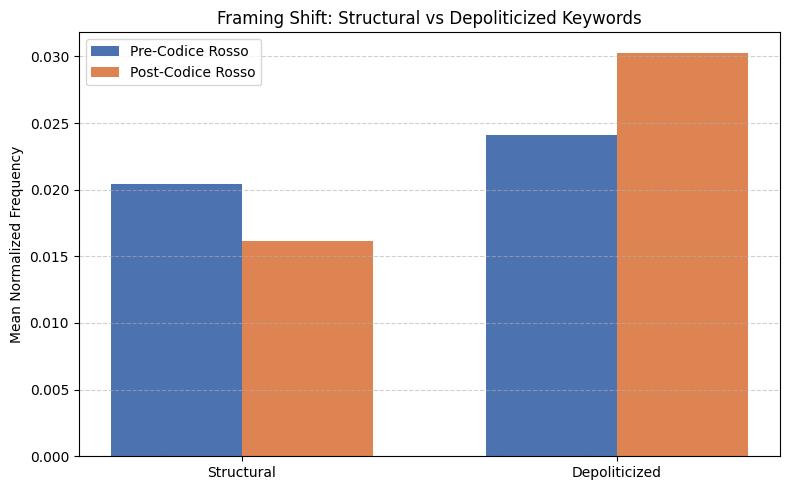

In [ ]:
import matplotlib.pyplot as plt

# Step 1: Define updated data
categories = ["Structural", "Depoliticized"]
pre_means = [0.02044, 0.02408]       # New mean normalized frequencies before Codice Rosso
post_means = [0.01614, 0.03029]      # New mean normalized frequencies after Codice Rosso

# Step 2: Set positions for grouped bars
x = range(len(categories))
bar_width = 0.35

# Step 3: Create the plot
plt.figure(figsize=(8, 5))

plt.bar(x, pre_means, width=bar_width, label='Pre-Codice Rosso', color="#4C72B0")
plt.bar([i + bar_width for i in x], post_means, width=bar_width, label='Post-Codice Rosso', color="#DD8452")

# Step 4: Format the plot
plt.xticks([i + bar_width / 2 for i in x], categories)
plt.ylabel("Mean Normalized Frequency")
plt.title("Framing Shift: Structural vs Depoliticized Keywords")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# Step 5: Save as PNG
plt.savefig("framing_shift_plot.png", dpi=300)

plt.show()

**Step Five: Method Two**

In [ ]:
!pip install spacy
!python -m spacy download it_core_news_sm
import spacy
nlp = spacy.load("it_core_news_sm")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 103.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('it_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import spacy
nlp = spacy.load("it_core_news_sm")

In [ ]:
import spacy

nlp = spacy.load("it_core_news_sm")
doc = nlp("Mario ha ucciso Laura con un coltello.")

for token in doc:
    print(f"{token.text:<12} {token.dep_:<10} {token.head.text:<12} {token.pos_:<6}")

Mario        nsubj      ucciso       PROPN 
ha           aux        ucciso       AUX   
ucciso       ROOT       ucciso       VERB  
Laura        obj        ucciso       PROPN 
con          case       coltello     ADP   
un           det        coltello     DET   
coltello     obl        ucciso       NOUN  
.            punct      ucciso       PUNCT 


In [ ]:
text = "La donna è stata uccisa dal compagno dopo una lite."
doc = nlp(text)

for token in doc:
    print(f"{token.text:<12} {token.pos_:<10} {token.dep_:<15} {token.head.text}")

La           DET        det             donna
donna        NOUN       nsubj:pass      uccisa
è            AUX        aux             uccisa
stata        AUX        aux:pass        uccisa
uccisa       VERB       ROOT            uccisa
dal          ADP        case            compagno
compagno     NOUN       obl:agent       uccisa
dopo         ADP        case            lite
una          DET        det             lite
lite         NOUN       obl             uccisa
.            PUNCT      punct           uccisa


In [ ]:
def detect_passive(doc):
    return any(t.dep_ == "aux:pass" and t.head.lemma_ in {"uccidere", "ammazzare"} for t in doc)

In [ ]:
def detect_active(doc):
    return any(t.dep_ == "nsubj" and t.head.lemma_ in {"uccidere", "ammazzare"} for t in doc)

In [ ]:
def detect_killing_frame(doc):
    return any(t.lemma_ in {"uccidere", "ammazzare", "assassinare"} for t in doc)

In [ ]:
import pandas as pd
import spacy
from collections import defaultdict, Counter
from tqdm.notebook import tqdm

# Load spaCy model
nlp = spacy.load("it_core_news_sm")

# Load datasets
pre_df = pd.read_csv("pre_codice_rosso.csv")
post_df = pd.read_csv("post_codice_rosso.csv")

# Lowercase cleaned_text
pre_df["cleaned_text"] = pre_df["cleaned_text"].str.lower()
post_df["cleaned_text"] = post_df["cleaned_text"].str.lower()

# Label datasets
pre_df["period"] = "pre"
post_df["period"] = "post"
df = pd.concat([pre_df, post_df], ignore_index=True)

# Define frame lexicons (lemmatized)
frame_lexicons = {
    "Killing": {"uccidere", "ammazzare", "assassinare", "strangolare"},
    "Death": {"morire", "morta", "decedere", "perire"},
    "Cause_Harm": {"colpire", "ferire", "accoltellare", "picchiare", "aggredire", "abusare"},
    "Event": {"trovare", "scoprire", "succedere", "avvenire", "sparare", "verificare"}
}
frame_verbs = set().union(*frame_lexicons.values())

# Named killers and masculine references
killer_names = {"impagnatiello", "alessandro", "padovani", "giovanni", "turetta", "filippo", "zani", "andrea", "logli", "antonio", "lissi", "alberto", "parolisi", "salvatore", "paduano", "marco", "capasso", "luigi"}
masculine_refs = {"lui", "l'uomo", "il ragazzo", "il marito", "il compagno", "il fidanzato", "l’assassino", "il killer"}

def classify_manual_syntax(doc):
    for token in doc:
        # Passive (e.g., "è stata uccisa") — exclude killer names and masculine refs
          if token.dep_ == "nsubj:pass" and (token.text.lower() not in killer_names) and (token.text.lower() not in masculine_refs) and token.head.lemma_ in frame_verbs:
            return "verbal:passive"

        # Impersonal (e.g., "si è saputo", "c'è stato")
          if token.text in {"si", "c’è", "c'è", "ci", "vi"} and token.head.lemma_ in frame_verbs:
            return "verbal:impersonal"

        # Active = masculine subject OR killer name + ANY verb
          if (token.text in masculine_refs or token.lemma_ in killer_names) and token.head.lemma_ in frame_verbs:
            return "verbal:active"

    return None

# Frame detection
def assign_frames(doc):
    lemmas = {token.lemma_.lower() for token in doc}
    return [frame for frame, keywords in frame_lexicons.items() if keywords & lemmas]

# Count frequencies
results = defaultdict(lambda: defaultdict(Counter))

# Batch processing
BATCH_SIZE = 500
for i in tqdm(range(0, len(df), BATCH_SIZE)):
    batch_df = df.iloc[i:i + BATCH_SIZE]
    docs = list(nlp.pipe(batch_df["cleaned_text"].astype(str)))
    for doc, (_, row) in zip(docs, batch_df.iterrows()):
        syntax = classify_manual_syntax(doc)
        if syntax is None:
            continue
        frames = assign_frames(doc)
        for frame in frames:
            results[frame][row["period"]][syntax] += 1

# Build final DataFrame
data = []
for frame in frame_lexicons:
    for period in ["pre", "post"]:
        for syntax in ["verbal:active", "verbal:passive", "verbal:impersonal"]:
            freq = results[frame][period][syntax]
            data.append({
                "Frame": frame,
                "Syntactic": syntax,
                "Period": period,
                "Frequency": freq
            })

df_summary = pd.DataFrame(data)
df_summary.to_csv("syntactic_frame_summary.csv", index=False)

  0%|          | 0/22 [00:00<?, ?it/s]

In [ ]:
from IPython.display import display
display(df_summary)

,Frame,Syntactic,Period,Frequency
0,Killing,verbal:active,pre,26
1,Killing,verbal:passive,pre,427
2,Killing,verbal:impersonal,pre,195
3,Killing,verbal:active,post,137
4,Killing,verbal:passive,post,1334
5,Killing,verbal:impersonal,post,613
6,Death,verbal:active,pre,11
7,Death,verbal:passive,pre,172
8,Death,verbal:impersonal,pre,94
9,Death,verbal:active,post,72


In [ ]:
from google.colab import files
files.download("syntactic_frame_summary.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

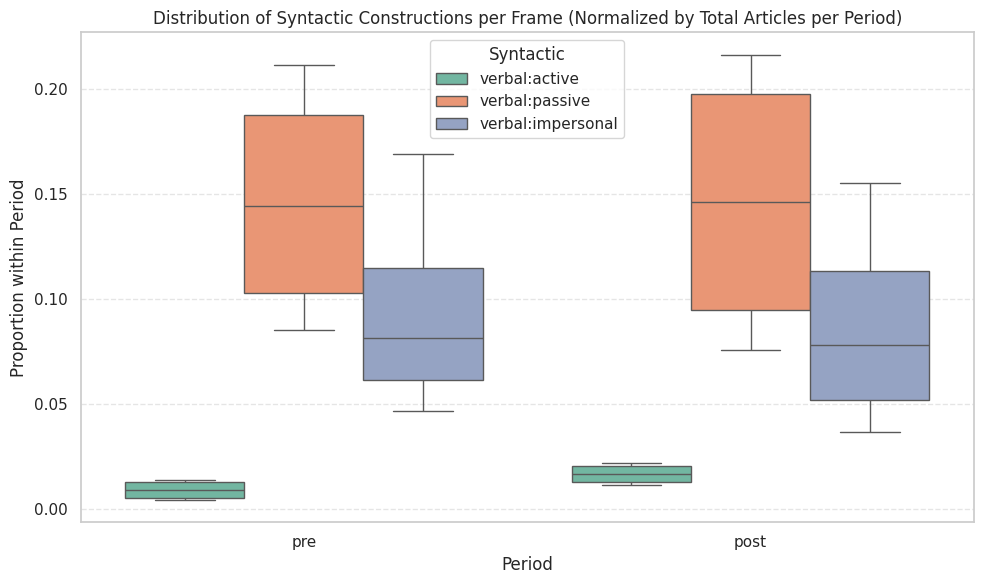

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Add proportions by period
summary = df_summary.copy()
total_by_period = summary.groupby("Period")["Frequency"].transform("sum")
summary["Proportion"] = summary["Frequency"] / total_by_period

# Plot boxplots: one per period
plt.figure(figsize=(10, 6))
sns.boxplot(data=summary, x="Period", y="Proportion", hue="Syntactic", palette="Set2")

plt.title("Distribution of Syntactic Constructions per Frame (Normalized by Total Articles per Period)")
plt.ylabel("Proportion within Period")
plt.xlabel("Period")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("box_plot.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
df_summary["Proportion"] = df_summary["Frequency"] / df_summary.groupby("Period")["Frequency"].transform("sum")

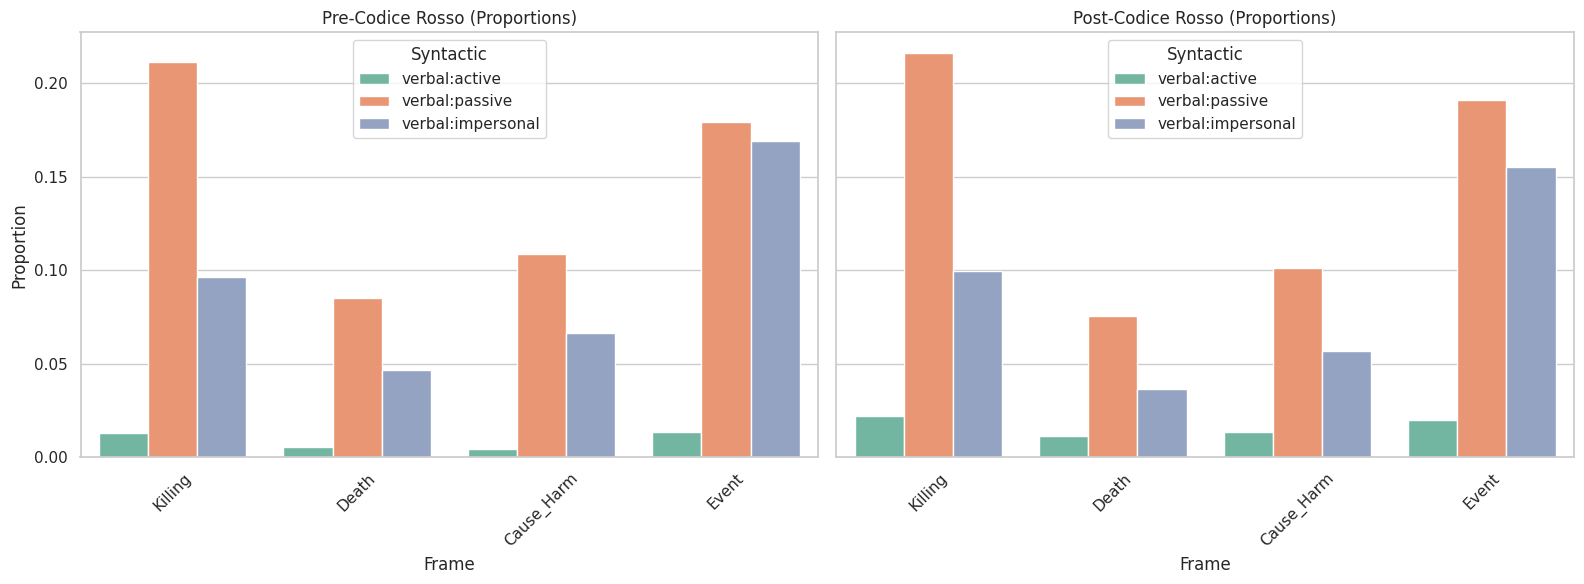

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set visual style
sns.set(style="whitegrid")

# Create figure with 2 subplots (one for pre, one for post)
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot for 'pre' period
sns.barplot(
    data=df_summary[df_summary["Period"] == "pre"],
    x="Frame",
    y="Proportion",
    hue="Syntactic",
    palette="Set2",
    ax=axes[0]
)
axes[0].set_title("Pre-Codice Rosso (Proportions)")
axes[0].set_ylabel("Proportion")
axes[0].set_xlabel("Frame")
axes[0].tick_params(axis='x', rotation=45)

# Plot for 'post' period
sns.barplot(
    data=df_summary[df_summary["Period"] == "post"],
    x="Frame",
    y="Proportion",
    hue="Syntactic",
    palette="Set2",
    ax=axes[1]
)
axes[1].set_title("Post-Codice Rosso (Proportions)")
axes[1].set_ylabel("")
axes[1].set_xlabel("Frame")
axes[1].tick_params(axis='x', rotation=45)

# Final layout
plt.tight_layout()
plt.savefig("bar_plot.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import norm

# Load summary CSV
df_summary = pd.read_csv("syntactic_frame_summary.csv")

# Normalize by total articles per period
total_docs = {
    "pre": df_summary[df_summary["Period"] == "pre"]["Frequency"].sum(),
    "post": df_summary[df_summary["Period"] == "post"]["Frequency"].sum()
}

# Create pivot to compare
pivot = df_summary.pivot_table(index=["Frame", "Syntactic"], columns="Period", values="Frequency", fill_value=0).reset_index()

# Merge proportions
pivot["pre_prop"] = pivot["pre"] / total_docs["pre"]
pivot["post_prop"] = pivot["post"] / total_docs["post"]

# Z-test for difference in proportions
def z_test(p1, n1, p2, n2):
    p = (p1 * n1 + p2 * n2) / (n1 + n2)
    se = np.sqrt(p * (1 - p) * (1/n1 + 1/n2))
    z = (p1 - p2) / se if se > 0 else 0
    p_val = 2 * (1 - norm.cdf(abs(z)))
    return z, p_val

# Apply test
z_scores, p_vals = [], []
for _, row in pivot.iterrows():
    z, p = z_test(row["pre_prop"], total_docs["pre"], row["post_prop"], total_docs["post"])
    z_scores.append(round(z, 2))
    p_vals.append(round(p, 3))

# Append results
pivot["z-score"] = z_scores
pivot["p-value"] = p_vals
pivot["Significance"] = pivot["p-value"].apply(lambda p: "✅ Yes (p < 0.05)" if p < 0.05 else "❌ No")

# Format percentage columns
pivot["Pre (%)"] = (pivot["pre_prop"] * 100).round(2)
pivot["Post (%)"] = (pivot["post_prop"] * 100).round(2)

# Final formatted table
final_table = pivot[["Frame", "Syntactic", "Pre (%)", "Post (%)", "z-score", "p-value", "Significance"]].sort_values(by="Frame")

from google.colab import data_table
data_table.DataTable(final_table)

Period,Frame,Syntactic,Pre (%),Post (%),z-score,p-value,Significance
0,Cause_Harm,verbal:active,0.45,1.35,-3.33,0.001,✅ Yes (p < 0.05)
1,Cause_Harm,verbal:impersonal,6.64,5.69,1.56,0.118,❌ No
2,Cause_Harm,verbal:passive,10.90,10.13,0.98,0.329,❌ No
3,Death,verbal:active,0.54,1.17,-2.42,0.015,✅ Yes (p < 0.05)
4,Death,verbal:impersonal,4.66,3.66,1.99,0.046,✅ Yes (p < 0.05)
5,Death,verbal:passive,8.52,7.57,1.38,0.169,❌ No
6,Event,verbal:active,1.39,2.01,-1.80,0.071,❌ No
7,Event,verbal:impersonal,16.89,15.52,1.46,0.143,❌ No
8,Event,verbal:passive,17.93,19.10,-1.17,0.242,❌ No
9,Killing,verbal:active,1.29,2.22,-2.61,0.009,✅ Yes (p < 0.05)


**Step Six: Method Three**

In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv("emotional_scores_combined.csv")

print(df.head())

                                     id  emotional_score period
0  c950280a-1c37-492e-a09b-cd19fef76404                2    pre
1  cc385159-64a0-4072-a506-b93afafe9de3                2    pre
2  9213451c-4372-4d86-905a-a6a753f8a228                2    pre
3  3e62c3dd-9940-4ffe-b2a2-023ff9b61ad6                2    pre
4  06c41498-4bd0-4b04-a995-069738049971                1    pre


In [2]:
pre_scores = df[df['period'] == 'pre']['emotional_score']
post_scores = df[df['period'] == 'post']['emotional_score']

In [3]:
print("number of articles pre-Codice Rosso:", len(pre_scores))
print ("number of articles post-Codice Rosso:", len(post_scores))

number of articles pre-Codice Rosso: 3128
number of articles post-Codice Rosso: 7643


In [4]:
pre_mean = pre_scores.mean()
post_mean = post_scores.mean()
pre_std = pre_scores.std()
post_std = post_scores.std()

print(f" Pre-Codice Rosso – Media: {pre_mean:.2f} | Deviazione standard: {pre_std:.2f}")
print(f" Post-Codice Rosso – Media: {post_mean:.2f} | Deviazione standard: {post_std:.2f}")

 Pre-Codice Rosso – Media: 1.99 | Deviazione standard: 0.58
 Post-Codice Rosso – Media: 1.01 | Deviazione standard: 0.57


In [5]:
!python3 -m pip install scipy

In [6]:
from scipy.stats import ttest_ind

# T-test (Welch’s t-test)
t_stat, p_val = ttest_ind(pre_scores, post_scores, equal_var=False)

print(f" T-test: t = {t_stat:.2f} | p = {p_val:.4f}")

 T-test: t = 79.72 | p = 0.0000


<ipython-input-8-0625a40a05fd>:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([pre_scores, post_scores],


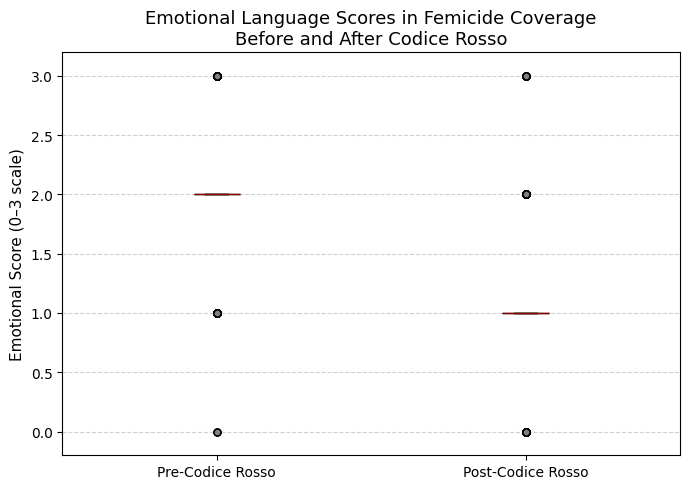

In [8]:
import matplotlib.pyplot as plt

# Create boxplot comparing the emotional scores
plt.figure(figsize=(7, 5))

plt.boxplot([pre_scores, post_scores],
            labels=['Pre-Codice Rosso', 'Post-Codice Rosso'],
            patch_artist=True,
            boxprops=dict(facecolor='#add8e6', color='black'),
            medianprops=dict(color='darkred'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'),
            flierprops=dict(marker='o', markerfacecolor='gray', markersize=5, linestyle='none', markeredgecolor='black'))

# Add title and labels
plt.title('Emotional Language Scores in Femicide Coverage\nBefore and After Codice Rosso', fontsize=13)
plt.ylabel('Emotional Score (0–3 scale)', fontsize=11)
plt.ylim(-0.2, 3.2)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# Show plot
plt.show()

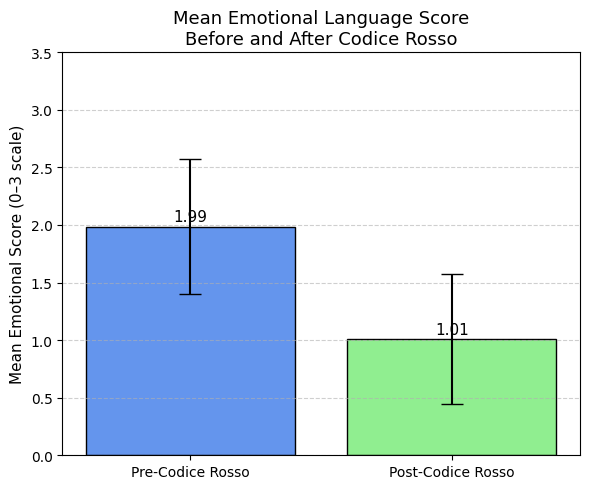

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate means and standard deviations
pre_mean = pre_scores.mean()
post_mean = post_scores.mean()
pre_std = pre_scores.std()
post_std = post_scores.std()

# Data for plotting
means = [pre_mean, post_mean]
stds = [pre_std, post_std]
labels = ['Pre-Codice Rosso', 'Post-Codice Rosso']

# Create the barplot
plt.figure(figsize=(6, 5))
bars = plt.bar(labels, means, yerr=stds, capsize=8, color=['#6495ED', '#90EE90'], edgecolor='black')

# Add value labels on top
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.05, f'{height:.2f}', ha='center', fontsize=11)

# Aesthetics
plt.ylim(0, 3.5)
plt.ylabel('Mean Emotional Score (0–3 scale)', fontsize=11)
plt.title('Mean Emotional Language Score\nBefore and After Codice Rosso', fontsize=13)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# Show the plot
plt.show()

In [10]:
import pandas as pd

df = pd.read_csv("sensational_scores_combined.csv")

print(df.head())

                                     id  sensational_score period
0  c950280a-1c37-492e-a09b-cd19fef76404                  2    pre
1  cc385159-64a0-4072-a506-b93afafe9de3                  2    pre
2  9213451c-4372-4d86-905a-a6a753f8a228                  2    pre
3  3e62c3dd-9940-4ffe-b2a2-023ff9b61ad6                  2    pre
4  06c41498-4bd0-4b04-a995-069738049971                  2    pre


In [11]:
pre_scores = df[df['period'] == 'pre']['sensational_score']
post_scores = df[df['period'] == 'post']['sensational_score']

In [12]:
print("number of articles pre-Codice Rosso:", len(pre_scores))
print ("number of articles post-Codice Rosso:", len(post_scores))

number of articles pre-Codice Rosso: 3128
number of articles post-Codice Rosso: 7643


In [13]:
pre_mean = pre_scores.mean()
post_mean = post_scores.mean()
pre_std = pre_scores.std()
post_std = post_scores.std()

print(f"Pre-Codice Rosso – Media: {pre_mean:.2f} | Deviazione standard: {pre_std:.2f}")
print(f"Post-Codice Rosso – Media: {post_mean:.2f} | Deviazione standard: {post_std:.2f}")

Pre-Codice Rosso – Media: 2.00 | Deviazione standard: 0.57
Post-Codice Rosso – Media: 1.01 | Deviazione standard: 0.57


In [14]:
from scipy.stats import ttest_ind

# T-test (Welch’s t-test)
t_stat, p_val = ttest_ind(pre_scores, post_scores, equal_var=False)

print(f" T-test: t = {t_stat:.2f} | p = {p_val:.4f}")

 T-test: t = 82.84 | p = 0.0000


<ipython-input-15-713c9a612ceb>:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([pre_scores, post_scores], labels=['Pre-Codice Rosso', 'Post-Codice Rosso'])


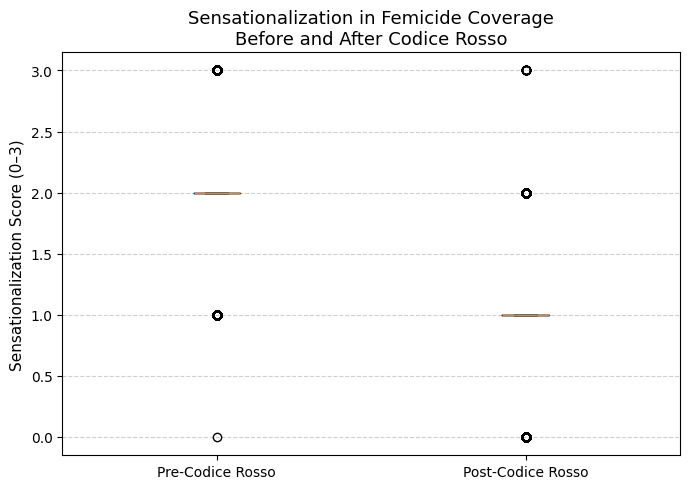

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
plt.boxplot([pre_scores, post_scores], labels=['Pre-Codice Rosso', 'Post-Codice Rosso'])

plt.title('Sensationalization in Femicide Coverage\nBefore and After Codice Rosso', fontsize=13)
plt.ylabel('Sensationalization Score (0–3)', fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

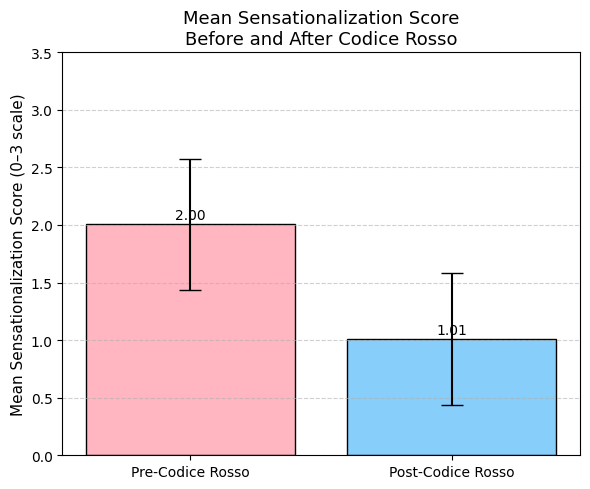

In [16]:
import numpy as np

means = [pre_mean, post_mean]
stds = [pre_std, post_std]
labels = ['Pre-Codice Rosso', 'Post-Codice Rosso']

plt.figure(figsize=(6, 5))
bars = plt.bar(labels, means, yerr=stds, capsize=8, color=['#FFB6C1', '#87CEFA'], edgecolor='black')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.05, f'{height:.2f}', ha='center')

plt.ylim(0, 3.5)
plt.ylabel('Mean Sensationalization Score (0–3 scale)', fontsize=11)
plt.title('Mean Sensationalization Score\nBefore and After Codice Rosso', fontsize=13)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()